Environment Setup and Imports

In [1]:
import findspark
findspark.init()

import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

from pyspark.sql import SparkSession, functions as F
from pyspark.sql.types import *
from pyspark.ml.feature import Tokenizer, StopWordsRemover, CountVectorizer, IDF

PROJECT_ROOT = Path(r"C:\Computer Science\AIMLDL\log-anomaly-detection")
DATASET_PATH = PROJECT_ROOT / "dataset"
RAW_DATA_PATH = DATASET_PATH / "raw_data"   
STRUCTURED_DATA_PATH = DATASET_PATH / "structured_data"
LABELED_DATA_PATH = DATASET_PATH / "labeled_data"  
NORMALIZED_DATA_PATH = LABELED_DATA_PATH / "normalized" 

NORMALIZED_DATA_PATH.mkdir(exist_ok=True)

os.environ['HADOOP_HOME'] = 'C:\\hadoop'
os.environ['PATH'] = f"{os.environ['HADOOP_HOME']}\\bin;{os.environ['PATH']}"

Spark Session Initialization

In [2]:
app_name = "LabeledLogAnomalyEDA"
spark = SparkSession.builder \
    .master("local[*]") \
    .config("spark.driver.memory", "10g") \
    .config("spark.driver.maxResultSize", "4g") \
    .config("spark.sql.adaptive.enabled", "true") \
    .config("spark.sql.adaptive.coalescePartitions.enabled", "true") \
    .config("spark.sql.execution.arrow.pyspark.enabled", "true") \
    .config("spark.serializer", "org.apache.spark.serializer.KryoSerializer") \
    .config("spark.sql.repl.eagerEval.enabled", "true") \
    .config("spark.sql.repl.eagerEval.maxNumRows", 20) \
    .config("spark.sql.shuffle.partitions", "8") \
    .appName(app_name) \
    .getOrCreate()

spark.sparkContext.setLogLevel("WARN")

print(f"Spark {spark.version}")
print(f"Available cores: {spark.sparkContext.defaultParallelism}")
print(f"Driver memory: {spark.conf.get('spark.driver.memory')}")
print("Spark session initialized successfully!")

Spark 3.4.1
Available cores: 20
Driver memory: 10g
Spark session initialized successfully!


Dataset Discovery

In [3]:
raw_files = list(RAW_DATA_PATH.glob("*.log"))
print(f"Raw Log Files Found: {len(raw_files)}")
for file in sorted(raw_files):
    size_mb = file.stat().st_size / (1024 * 1024)
    print(f"   {file.name:<25} | {size_mb:>8.2f} MB")

print()

structured_files = list(STRUCTURED_DATA_PATH.glob("*_structured.csv"))
print(f"Structured CSV Files Found: {len(structured_files)}")
for file in sorted(structured_files):
    size_mb = file.stat().st_size / (1024 * 1024)
    print(f"   {file.name:<35} | {size_mb:>8.2f} MB")

print()

labeled_files = list(LABELED_DATA_PATH.glob("*_labeled.csv"))
print(f"Labeled CSV Files Found: {len(labeled_files)}")
for file in sorted(labeled_files):
    size_mb = file.stat().st_size / (1024 * 1024)
    print(f"   {file.name:<35} | {size_mb:>8.2f} MB")

print()

normalized_files = list(NORMALIZED_DATA_PATH.glob("*_normalized.csv")) if NORMALIZED_DATA_PATH.exists() else []
print(f"Normalized CSV Files Found: {len(normalized_files)}")
for file in sorted(normalized_files):
    size_mb = file.stat().st_size / (1024 * 1024)
    print(f"   {file.name:<35} | {size_mb:>8.2f} MB")

print(f"\n=== SUMMARY ===")
print(f"Total raw files: {len(raw_files)}")
print(f"Total structured files: {len(structured_files)}")
print(f"Total labeled files: {len(labeled_files)}")
print(f"Total normalized files: {len(normalized_files)}")

Raw Log Files Found: 16
   Android_2k.log            |     0.27 MB
   Apache_2k.log             |     0.16 MB
   BGL_2k.log                |     0.30 MB
   Hadoop_2k.log             |     0.37 MB
   HDFS_2k.log               |     0.27 MB
   HealthApp_2k.log          |     0.18 MB
   HPC_2k.log                |     0.14 MB
   Linux_2k.log              |     0.21 MB
   Mac_2k.log                |     0.30 MB
   OpenSSH_2k.log            |     0.21 MB
   OpenStack_2k.log          |     0.57 MB
   Proxifier_2k.log          |     0.23 MB
   Spark_2k.log              |     0.19 MB
   Thunderbird_2k.log        |     0.31 MB
   Windows_2k.log            |     0.27 MB
   Zookeeper_2k.log          |     0.27 MB

Structured CSV Files Found: 16
   Android_2k.log_structured.csv       |     0.43 MB
   Apache_2k.log_structured.csv        |     0.25 MB
   BGL_2k.log_structured.csv           |     0.41 MB
   Hadoop_2k.log_structured.csv        |     0.52 MB
   HDFS_2k.log_structured.csv          |    

In [4]:
def load_labeled_data_spark(csv_file_path):
    try:
        df = spark.read \
            .option("header", "true") \
            .option("inferSchema", "true") \
            .option("multiline", "true") \
            .option("escape", '"') \
            .option("quote", '"') \
            .csv(str(csv_file_path))
        
        return df
    
    except Exception as e:
        print(f"Error loading {csv_file_path.name}: {e}")
        return None

def detect_log_type_from_filename(filename):
    filename = filename.lower()
    if 'android' in filename:
        return 'Android'
    elif 'apache' in filename:
        return 'Apache'
    elif 'bgl' in filename:
        return 'BGL'
    elif 'hadoop' in filename:
        return 'Hadoop'
    elif 'hdfs' in filename:
        return 'HDFS'
    elif 'health' in filename:
        return 'HealthApp'
    elif 'hpc' in filename:
        return 'HPC'
    elif 'linux' in filename:
        return 'Linux'
    elif 'mac' in filename:
        return 'Mac'
    elif 'openssh' in filename:
        return 'OpenSSH'
    elif 'openstack' in filename:
        return 'OpenStack'
    elif 'proxifier' in filename:
        return 'Proxifier'
    elif 'spark' in filename:
        return 'Spark'
    elif 'thunderbird' in filename:
        return 'Thunderbird'
    elif 'windows' in filename:
        return 'Windows'
    elif 'zookeeper' in filename or 'zookeper' in filename:
        return 'Zookeeper'
    else:
        return 'Unknown'

In [22]:
def analyze_labeled_dataset(df, dataset_name):
    if df is None:
        return None
    
    print(f"\n=== {dataset_name} ANALYSIS ===")
    
    row_count = df.count()
    col_count = len(df.columns)
    log_type = detect_log_type_from_filename(dataset_name)
    
    print(f"Log Type: {log_type}")
    print(f"Dimensions: {row_count:,} rows × {col_count} columns")
    print(f"Columns: {', '.join(df.columns)}")
    
    print(f"\nSchema:")
    df.printSchema()
    
    print(f"\nSample Data (first 3 rows):")
    df.show(3, truncate=False)
    
    if 'Label' in df.columns:
        print(f"\n=== LABEL ANALYSIS ===")
        label_counts = df.groupBy('Label').count().orderBy(F.desc('count'))
        label_distribution = label_counts.collect()
        
        print("Label Distribution:")
        total_labels = sum([row['count'] for row in label_distribution])
        for row in label_distribution:
            percentage = (row['count'] / total_labels) * 100
            print(f"   {row['Label']:<15} | {row['count']:>8,} ({percentage:>5.1f}%)")
        
        normal_count = sum([row['count'] for row in label_distribution if row['Label'].lower() in ['normal', '0', 'benign']])
        anomaly_count = total_labels - normal_count
        anomaly_rate = (anomaly_count / total_labels) * 100
        
        print(f"\nAnomaly Statistics:")
        print(f"   Normal logs: {normal_count:,} ({100-anomaly_rate:.1f}%)")
        print(f"   Anomalous logs: {anomaly_count:,} ({anomaly_rate:.1f}%)")
    
    print(f"\nDetailed Column Statistics:")
    for col in df.columns:
        null_count = df.filter(F.col(col).isNull()).count()
        null_pct = (null_count / row_count) * 100
        
        if df.schema[col].dataType == StringType():
            distinct_count = df.select(col).distinct().count()
            avg_length = df.select(F.avg(F.length(F.col(col))).alias("avg_len")).collect()[0]["avg_len"]
            avg_length = avg_length if avg_length else 0
            print(f"   {col:<15} | Nulls: {null_count:>6} ({null_pct:>5.1f}%) | Distinct: {distinct_count:>8} | Avg Length: {avg_length:>6.1f}")
        else:
            print(f"   {col:<15} | Nulls: {null_count:>6} ({null_pct:>5.1f}%)")
    
    timestamp_cols = [col for col in df.columns if any(keyword in col.lower() for keyword in ['time', 'date', 'timestamp'])]
    if timestamp_cols:
        print(f"\n=== TIMESTAMP ANALYSIS ===")
        print(f"Timestamp columns found: {timestamp_cols}")
        for col in timestamp_cols:
            sample_values = df.select(col).filter(F.col(col).isNotNull()).limit(5).collect()
            print(f"   {col}: {[row[col] for row in sample_values]}")
    
    return {
        'name': dataset_name,
        'log_type': log_type,
        'rows': row_count,
        'columns': col_count,
        'column_names': df.columns,
        'schema': df.schema,
        'has_labels': 'Label' in df.columns,
        'timestamp_columns': [col for col in df.columns if any(keyword in col.lower() for keyword in ['time', 'date', 'timestamp'])],
        'label_summary': {
            'dataset': dataset_name.replace('_labeled.csv', ''),
            'total_records': row_count,
            'normal_count': normal_count,
            'anomaly_count': anomaly_count,
            'anomaly_rate': anomaly_rate
        } if 'Label' in df.columns else None
    }

In [23]:
labeled_datasets_info = []
labeled_spark_dfs = {}

for file_path in sorted(labeled_files):
    dataset_name = file_path.name
    print(f"\nLoading {dataset_name}...")
    
    try:
        df = load_labeled_data_spark(file_path)
        
        if df is not None:
            labeled_spark_dfs[dataset_name] = df
            
            info = analyze_labeled_dataset(df, dataset_name)
            
            if info:
                labeled_datasets_info.append(info)
                
    except Exception as e:
        print(f"Error processing {dataset_name}: {str(e)}")

label_analyses = []
for info in labeled_datasets_info:
    if info['label_summary']:
        label_analyses.append(info['label_summary'])

print(f"\n=== PROCESSING SUMMARY ===")
print(f"Successfully loaded: {len(labeled_spark_dfs)} datasets")
print(f"Analysis completed: {len(labeled_datasets_info)} datasets")

if labeled_datasets_info:
    print(f"\nDatasets processed:")
    for info in labeled_datasets_info:
        print(f"   {info['name']:<35} | {info['log_type']:<12} | {info['rows']:>8,} rows | {info['columns']:>2} cols")


Loading Apache_2k_labeled.csv...

=== Apache_2k_labeled.csv ANALYSIS ===
Log Type: Apache
Dimensions: 2,000 rows × 9 columns
Columns: LineId, Time, Level, Content, EventId, EventTemplate, AnomalyLabel, AnomalyLabelName, Source

Schema:
root
 |-- LineId: integer (nullable = true)
 |-- Time: string (nullable = true)
 |-- Level: string (nullable = true)
 |-- Content: string (nullable = true)
 |-- EventId: string (nullable = true)
 |-- EventTemplate: string (nullable = true)
 |-- AnomalyLabel: integer (nullable = true)
 |-- AnomalyLabelName: string (nullable = true)
 |-- Source: string (nullable = true)


Sample Data (first 3 rows):
+------+------------------------+------+-------------------------------------------------------+-------+-------------------------------------------------+------------+----------------+---------+
|LineId|Time                    |Level |Content                                                |EventId|EventTemplate                                    |AnomalyLabel|

Cross-Dataset Schema Analysis

In [7]:
if not labeled_datasets_info:
    print("No labeled datasets loaded for schema analysis")
else:
    all_labeled_columns = set()
    for info in labeled_datasets_info:
        all_labeled_columns.update(info['column_names'])

    print(f"Total unique columns across all labeled datasets: {len(all_labeled_columns)}")
    print(f"All columns: {sorted(all_labeled_columns)}")

    schema_matrix = []
    for info in labeled_datasets_info:
        row = []
        for col in sorted(all_labeled_columns):
            row.append(1 if col in info['column_names'] else 0)
        schema_matrix.append(row)

    schema_df = pd.DataFrame(
        schema_matrix,
        columns=sorted(all_labeled_columns),
        index=[info['name'].replace('_labeled.csv', '') for info in labeled_datasets_info]
    )

    print(f"\nSchema Compatibility Matrix:")
    print(schema_df.to_string())

    universal_labeled_columns = []
    for col in sorted(all_labeled_columns):
        if schema_df[col].sum() == len(labeled_datasets_info):
            universal_labeled_columns.append(col)

    print(f"\nUniversal columns (present in ALL labeled datasets): {universal_labeled_columns}")

    datasets_with_labels = [info for info in labeled_datasets_info if info['has_labels']]
    print(f"\nDatasets with Label columns: {len(datasets_with_labels)}/{len(labeled_datasets_info)}")
    
    for info in datasets_with_labels:
        print(f"   ✓ {info['name'].replace('_labeled.csv', '')}")
    
    timestamp_column_summary = {}
    for info in labeled_datasets_info:
        dataset_name = info['name'].replace('_labeled.csv', '')
        timestamp_column_summary[dataset_name] = info['timestamp_columns']
    
    print(f"\nTimestamp Columns Summary:")
    for dataset, cols in timestamp_column_summary.items():
        print(f"   {dataset:<15} | {', '.join(cols) if cols else 'No timestamp columns'}")
    
    schema_analysis = {
        'universal_columns': universal_labeled_columns,
        'all_columns': sorted(all_labeled_columns),
        'schema_matrix': schema_df.to_dict(),
        'datasets_with_labels': [info['name'] for info in datasets_with_labels],
        'timestamp_columns': timestamp_column_summary
    }

Total unique columns across all labeled datasets: 23
All columns: ['AnomalyLabel', 'AnomalyLabelName', 'Component', 'Content', 'Date', 'Day', 'EventId', 'EventTemplate', 'Flag', 'Id', 'Label', 'Level', 'LineId', 'LogId', 'Node', 'NodeRepeat', 'Pid', 'Program', 'Source', 'State', 'Time', 'Timestamp', 'Type']

Schema Compatibility Matrix:
              AnomalyLabel  AnomalyLabelName  Component  Content  Date  Day  EventId  EventTemplate  Flag  Id  Label  Level  LineId  LogId  Node  NodeRepeat  Pid  Program  Source  State  Time  Timestamp  Type
Apache_2k                1                 1          0        1     0    0        1              1     0   0      0      1       1      0     0           0    0        0       1      0     1          0     0
BGL_2k                   1                 1          1        1     1    0        1              1     0   0      1      1       1      0     1           1    0        0       1      0     1          1     1
HPC_2k                   1        

Data Quality Analysis

In [8]:
def assess_labeled_data_quality(df, dataset_name):
    if df is None:
        return None
    
    print(f"\n=== DATA QUALITY ASSESSMENT: {dataset_name} ===")
    
    total_rows = df.count()
    quality_report = {
        'dataset_name': dataset_name,
        'total_rows': total_rows,
        'columns': {},
        'overall_quality_score': 0
    }
    
    quality_scores = []
    
    for col_name in df.columns:
        col_data = df.select(col_name)
        
        null_count = col_data.filter(F.col(col_name).isNull()).count()
        null_percentage = (null_count / total_rows) * 100
        
        empty_count = 0
        if df.schema[col_name].dataType == StringType():
            empty_count = col_data.filter(
                (F.col(col_name) == "") | 
                (F.trim(F.col(col_name)) == "")
            ).count()
        
        distinct_count = col_data.distinct().count()
        
        completeness = 100 - null_percentage
        empty_penalty = (empty_count / total_rows) * 100 if total_rows > 0 else 0
        column_quality = max(0, completeness - empty_penalty)
        
        quality_scores.append(column_quality)
        
        quality_report['columns'][col_name] = {
            'null_count': null_count,
            'null_percentage': null_percentage,
            'empty_count': empty_count,
            'distinct_count': distinct_count,
            'completeness': completeness,
            'quality_score': column_quality
        }
        
        print(f"{col_name}:")
        print(f"   Quality Score: {column_quality:.1f}/100")
        print(f"   Completeness: {completeness:.1f}%")
        print(f"   Null values: {null_count:,} ({null_percentage:.1f}%)")
        if empty_count > 0:
            print(f"   Empty values: {empty_count:,} ({empty_penalty:.1f}%)")
        print(f"   Distinct values: {distinct_count:,}")
        
        if col_name == 'Label':
            print(f"   *** LABEL COLUMN ANALYSIS ***")
            if null_count > 0:
                print(f"   ⚠️  WARNING: {null_count:,} missing labels detected!")
            if empty_count > 0:
                print(f"   ⚠️  WARNING: {empty_count:,} empty labels detected!")
            print(f"   Label diversity: {distinct_count} unique labels")
        
        print()
    
    overall_quality = np.mean(quality_scores) if quality_scores else 0
    quality_report['overall_quality_score'] = overall_quality
    
    print(f"OVERALL DATA QUALITY SCORE: {overall_quality:.1f}/100")
    
    if overall_quality >= 90:
        quality_class = "EXCELLENT"
    elif overall_quality >= 80:
        quality_class = "GOOD"
    elif overall_quality >= 70:
        quality_class = "FAIR"
    elif overall_quality >= 60:
        quality_class = "POOR"
    else:
        quality_class = "CRITICAL"
    
    print(f"Quality Classification: {quality_class}")
    
    return quality_report

def assess_timestamp_quality(df, dataset_name, timestamp_columns):
    if not timestamp_columns or df is None:
        return None
        
    print(f"\n=== TIMESTAMP QUALITY ASSESSMENT: {dataset_name} ===")
    
    for col in timestamp_columns:
        if col not in df.columns:
            continue
            
        print(f"\nTimestamp Column: {col}")
        
        total_rows = df.count()
        null_count = df.filter(F.col(col).isNull()).count()
        non_null_count = total_rows - null_count
        
        print(f"   Total rows: {total_rows:,}")
        print(f"   Non-null timestamps: {non_null_count:,} ({(non_null_count/total_rows*100):.1f}%)")
        print(f"   Null timestamps: {null_count:,} ({(null_count/total_rows*100):.1f}%)")
        
        if non_null_count > 0:
            sample_timestamps = df.select(col).filter(F.col(col).isNotNull()).limit(10).collect()
            print(f"   Sample formats:")
            for i, row in enumerate(sample_timestamps[:5], 1):
                print(f"      {i}. {row[col]}")

if labeled_spark_dfs:
    labeled_quality_reports = []
    
    for dataset_name, df in labeled_spark_dfs.items():
        report = assess_labeled_data_quality(df, dataset_name)
        if report:
            labeled_quality_reports.append(report)
        
        dataset_info = next((info for info in labeled_datasets_info if info['name'] == dataset_name), None)
        if dataset_info and dataset_info['timestamp_columns']:
            assess_timestamp_quality(df, dataset_name, dataset_info['timestamp_columns'])
    
    print(f"\n=== QUALITY ASSESSMENT SUMMARY ===")
    print(f"Datasets assessed: {len(labeled_quality_reports)}")
    
    quality_ranking = sorted(labeled_quality_reports, key=lambda x: x['overall_quality_score'], reverse=True)
    print(f"\nQuality Ranking (Best to Worst):")
    for i, report in enumerate(quality_ranking, 1):
        dataset_name = report['dataset_name'].replace('_labeled.csv', '')
        score = report['overall_quality_score']
        print(f"   {i:2d}. {dataset_name:<20} | {score:5.1f}/100")
    
else:
    print("No labeled datasets available for quality assessment")


=== DATA QUALITY ASSESSMENT: Apache_2k_labeled.csv ===
LineId:
   Quality Score: 100.0/100
   Completeness: 100.0%
   Null values: 0 (0.0%)
   Distinct values: 2,000

Time:
   Quality Score: 100.0/100
   Completeness: 100.0%
   Null values: 0 (0.0%)
   Distinct values: 759

Level:
   Quality Score: 100.0/100
   Completeness: 100.0%
   Null values: 0 (0.0%)
   Distinct values: 2

Content:
   Quality Score: 100.0/100
   Completeness: 100.0%
   Null values: 0 (0.0%)
   Distinct values: 886

EventId:
   Quality Score: 100.0/100
   Completeness: 100.0%
   Null values: 0 (0.0%)
   Distinct values: 6

EventTemplate:
   Quality Score: 100.0/100
   Completeness: 100.0%
   Null values: 0 (0.0%)
   Distinct values: 6

AnomalyLabel:
   Quality Score: 100.0/100
   Completeness: 100.0%
   Null values: 0 (0.0%)
   Distinct values: 3

AnomalyLabelName:
   Quality Score: 100.0/100
   Completeness: 100.0%
   Null values: 0 (0.0%)
   Distinct values: 3

Source:
   Quality Score: 100.0/100
   Completenes

Data Quality Assessment

In [10]:
def assess_data_quality(df, dataset_name):
    if df is None:
        return None
    
    print(f"\n=== DATA QUALITY ASSESSMENT: {dataset_name} ===")
    
    total_rows = df.count()
    quality_report = {
        'dataset_name': dataset_name,
        'total_rows': total_rows,
        'columns': {}
    }
    
    for col_name in df.columns:
        col_data = df.select(col_name)
        
        null_count = col_data.filter(F.col(col_name).isNull()).count()
        null_percentage = (null_count / total_rows) * 100
        
        empty_count = 0
        if df.schema[col_name].dataType == StringType():
            empty_count = col_data.filter(
                (F.col(col_name) == "") | 
                (F.trim(F.col(col_name)) == "")
            ).count()
        
        distinct_count = col_data.distinct().count()
        
        quality_report['columns'][col_name] = {
            'null_count': null_count,
            'null_percentage': null_percentage,
            'empty_count': empty_count,
            'distinct_count': distinct_count,
            'completeness': 100 - null_percentage
        }
        
        print(f"{col_name}:")
        print(f"   Completeness: {100 - null_percentage:.1f}%")
        print(f"   Null values: {null_count:,} ({null_percentage:.1f}%)")
        if empty_count > 0:
            print(f"   Empty values: {empty_count:,}")
        print(f"   Distinct values: {distinct_count:,}")
        print()
    
    return quality_report

quality_reports = []
for dataset_name, df in spark_dfs.items():
    report = assess_data_quality(df, dataset_name)
    if report:
        quality_reports.append(report)



=== DATA QUALITY ASSESSMENT: Android_2k.log_structured.csv ===
LineId:
   Completeness: 100.0%
   Null values: 0 (0.0%)
   Distinct values: 2,000

Date:
   Completeness: 100.0%
   Null values: 0 (0.0%)
   Distinct values: 1

Time:
   Completeness: 100.0%
   Null values: 0 (0.0%)
   Distinct values: 1,315

Pid:
   Completeness: 100.0%
   Null values: 0 (0.0%)
   Distinct values: 10

Tid:
   Completeness: 100.0%
   Null values: 0 (0.0%)
   Distinct values: 66

Level:
   Completeness: 100.0%
   Null values: 0 (0.0%)
   Distinct values: 5

Component:
   Completeness: 100.0%
   Null values: 0 (0.0%)
   Distinct values: 19

Content:
   Completeness: 100.0%
   Null values: 0 (0.0%)
   Distinct values: 438

EventId:
   Completeness: 100.0%
   Null values: 0 (0.0%)
   Distinct values: 166

EventTemplate:
   Completeness: 100.0%
   Null values: 0 (0.0%)
   Distinct values: 166


=== DATA QUALITY ASSESSMENT: Apache_2k.log_structured.csv ===
LineId:
   Completeness: 100.0%
   Null values: 0 (0.0%

Visualization

In [9]:
plt.style.use('default')
fig_size = (14, 6)

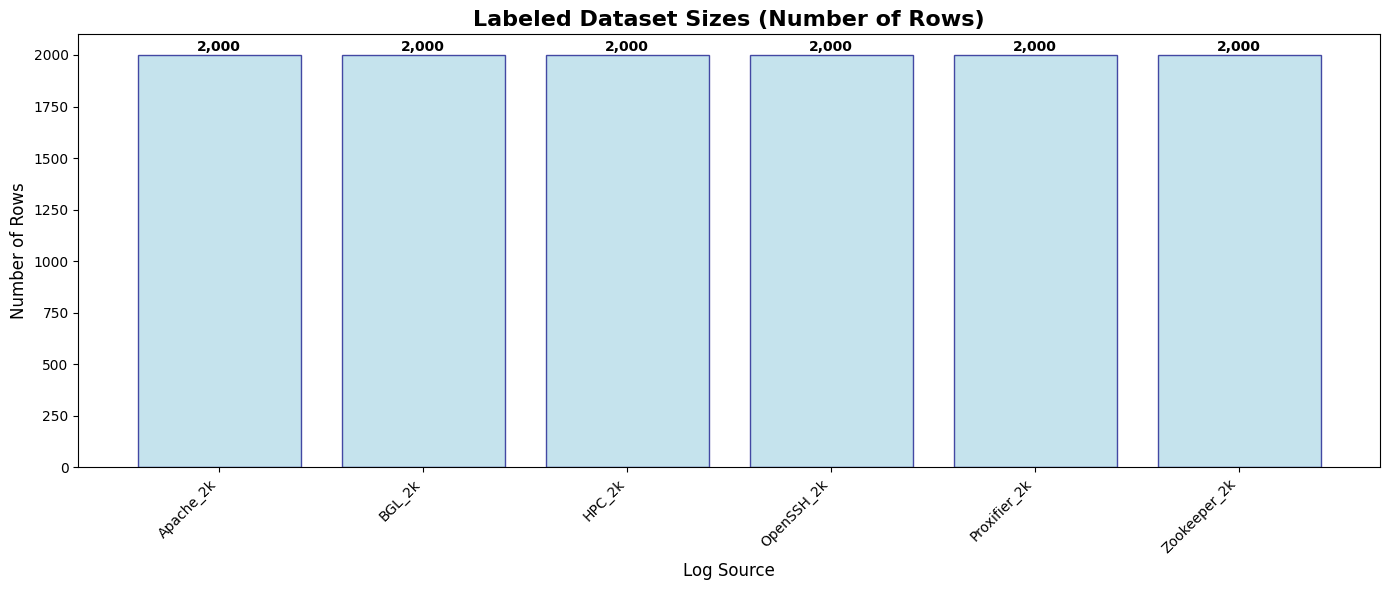

In [10]:
if not labeled_datasets_info:
    print("No labeled dataset information available for visualization")
else:
    dataset_names = [info['name'].replace('_labeled.csv', '') for info in labeled_datasets_info]
    row_counts = [info['rows'] for info in labeled_datasets_info]
    
    plt.figure(figsize=fig_size)
    bars = plt.bar(range(len(dataset_names)), row_counts, color='lightblue', alpha=0.7, edgecolor='navy')
    plt.title('Labeled Dataset Sizes (Number of Rows)', fontsize=16, fontweight='bold')
    plt.xlabel('Log Source', fontsize=12)
    plt.ylabel('Number of Rows', fontsize=12)
    plt.xticks(range(len(dataset_names)), dataset_names, rotation=45, ha='right')

    for bar, count in zip(bars, row_counts):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(row_counts)*0.01, 
                 f'{count:,}', ha='center', fontweight='bold', fontsize=10)

    plt.tight_layout()
    plt.show()

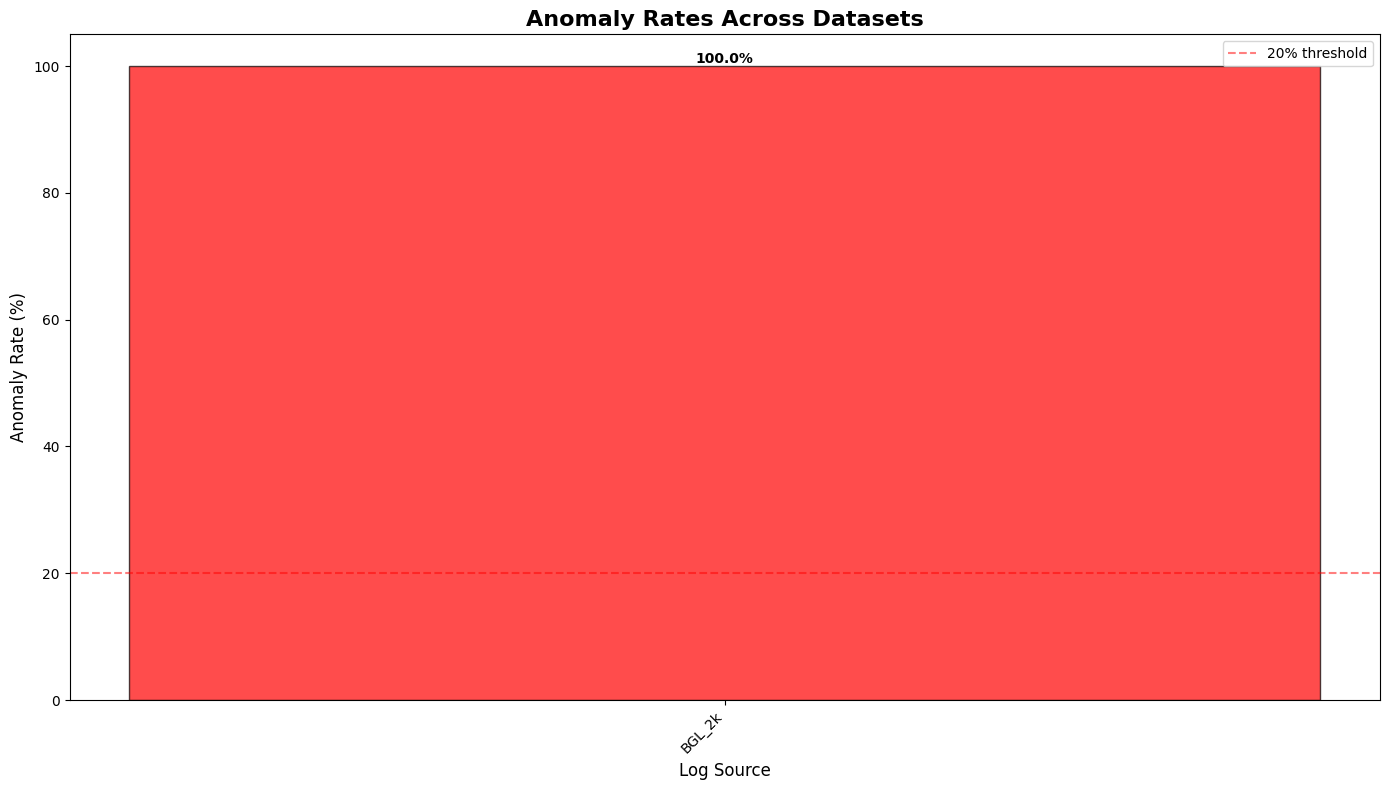

In [24]:
plt.figure(figsize=fig_size)

anomaly_rates = [analysis['anomaly_rate'] for analysis in label_analyses]
dataset_names_labels = [analysis['dataset'] for analysis in label_analyses]

colors = ['green' if rate < 10 else 'orange' if rate < 30 else 'red' for rate in anomaly_rates]
bars = plt.bar(range(len(dataset_names_labels)), anomaly_rates, color=colors, alpha=0.7, edgecolor='black')

plt.title('Anomaly Rates Across Datasets', fontsize=16, fontweight='bold')
plt.xlabel('Log Source', fontsize=12)
plt.ylabel('Anomaly Rate (%)', fontsize=12)
plt.xticks(range(len(dataset_names_labels)), dataset_names_labels, rotation=45, ha='right')

for bar, rate in zip(bars, anomaly_rates):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5, f'{rate:.1f}%', 
             ha='center', fontweight='bold', fontsize=10)

plt.axhline(y=20, color='red', linestyle='--', alpha=0.5, label='20% threshold')
plt.legend()
plt.tight_layout()
plt.show()

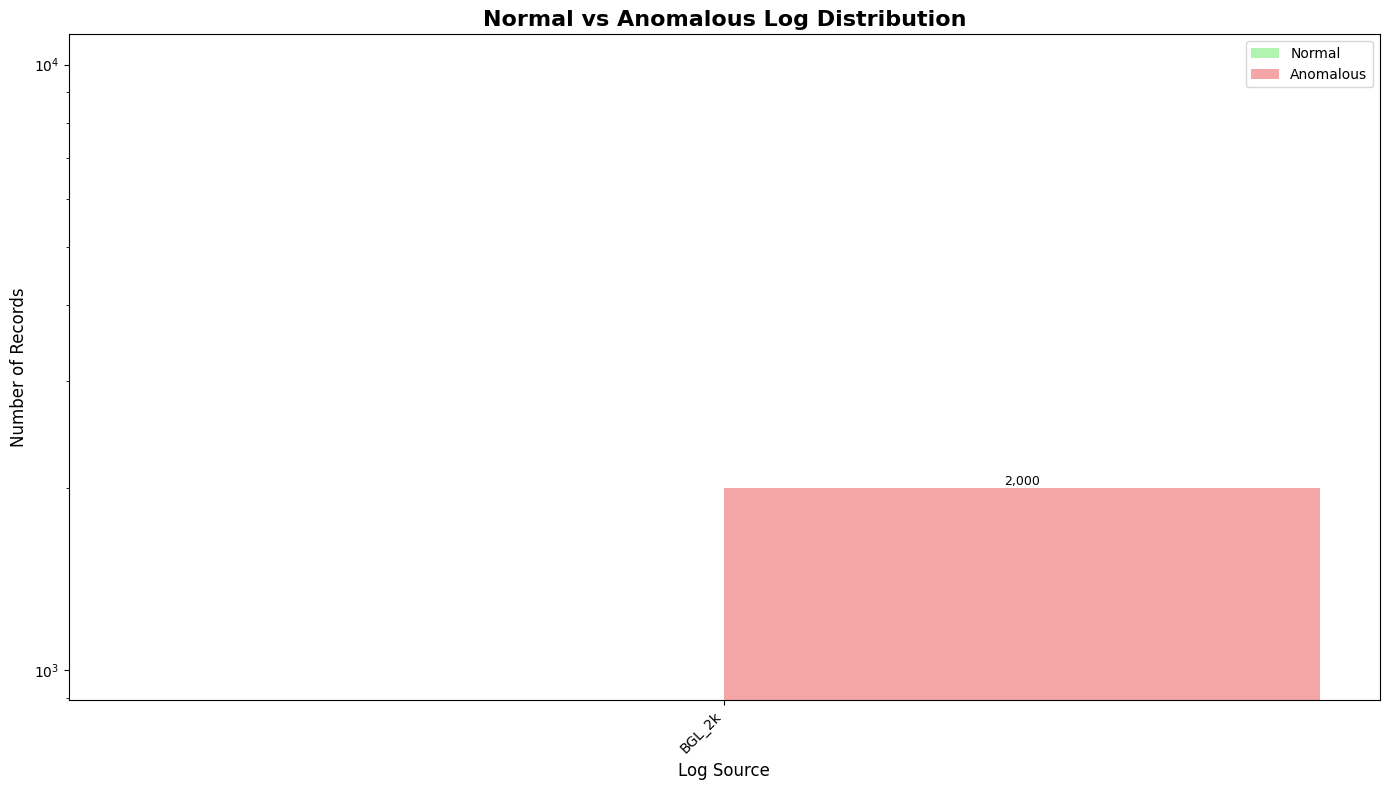

In [25]:
plt.figure(figsize=fig_size)

normal_counts = [analysis['normal_count'] for analysis in label_analyses]
anomaly_counts = [analysis['anomaly_count'] for analysis in label_analyses]

x_pos = np.arange(len(dataset_names_labels))
width = 0.35

bars1 = plt.bar(x_pos - width/2, normal_counts, width, label='Normal', color='lightgreen', alpha=0.7)
bars2 = plt.bar(x_pos + width/2, anomaly_counts, width, label='Anomalous', color='lightcoral', alpha=0.7)

plt.title('Normal vs Anomalous Log Distribution', fontsize=16, fontweight='bold')
plt.xlabel('Log Source', fontsize=12)
plt.ylabel('Number of Records', fontsize=12)
plt.xticks(x_pos, dataset_names_labels, rotation=45, ha='right')
plt.legend()

for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        if height > 0:
            plt.text(bar.get_x() + bar.get_width()/2, height + max(max(normal_counts), max(anomaly_counts))*0.01,
                    f'{int(height):,}', ha='center', fontsize=9)

plt.yscale('log')
plt.tight_layout()
plt.show()

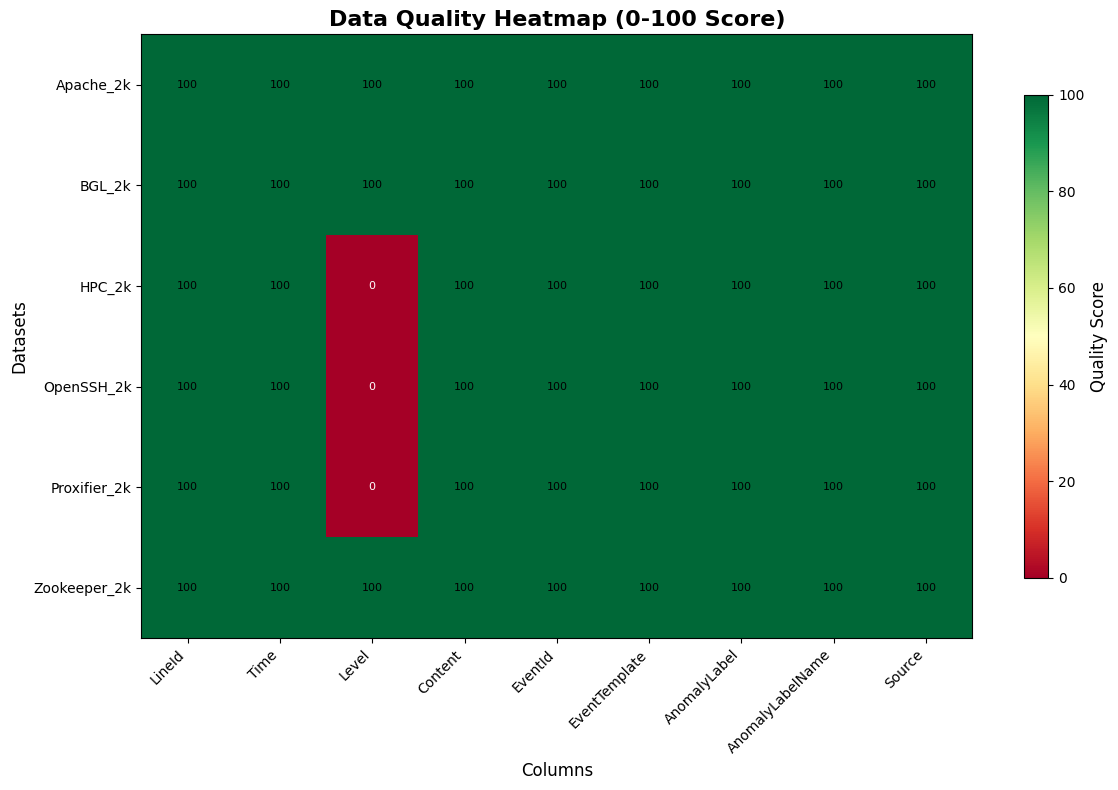

In [15]:
if 'labeled_quality_reports' in locals() and labeled_quality_reports:
    quality_data = []
    quality_dataset_names = []
    column_names_for_heatmap = []

    for report in labeled_quality_reports:
        if report and report['columns']:
            quality_dataset_names.append(report['dataset_name'].replace('_labeled.csv', ''))

            if not column_names_for_heatmap:
                column_names_for_heatmap = list(report['columns'].keys())

            quality_row = []
            for col in column_names_for_heatmap:
                quality_row.append(report['columns'][col]['quality_score'] if col in report['columns'] else 0)
            quality_data.append(quality_row)

    if quality_data:
        plt.figure(figsize=(max(12, len(column_names_for_heatmap)), max(8, len(quality_dataset_names))))
        quality_matrix = np.array(quality_data)

        im = plt.imshow(quality_matrix, cmap='RdYlGn', aspect='auto', vmin=0, vmax=100)
        plt.title('Data Quality Heatmap (0-100 Score)', fontsize=16, fontweight='bold')
        plt.xlabel('Columns', fontsize=12)
        plt.ylabel('Datasets', fontsize=12)
        plt.xticks(range(len(column_names_for_heatmap)), column_names_for_heatmap, rotation=45, ha='right')
        plt.yticks(range(len(quality_dataset_names)), quality_dataset_names)

        for i in range(len(quality_dataset_names)):
            for j in range(len(column_names_for_heatmap)):
                plt.text(j, i, f'{quality_matrix[i, j]:.0f}', ha="center", va="center",
                         color="black" if quality_matrix[i, j] > 50 else "white", fontsize=8)

        cbar = plt.colorbar(im, shrink=0.8)
        cbar.set_label('Quality Score', fontsize=12)

        plt.tight_layout()
        plt.show()

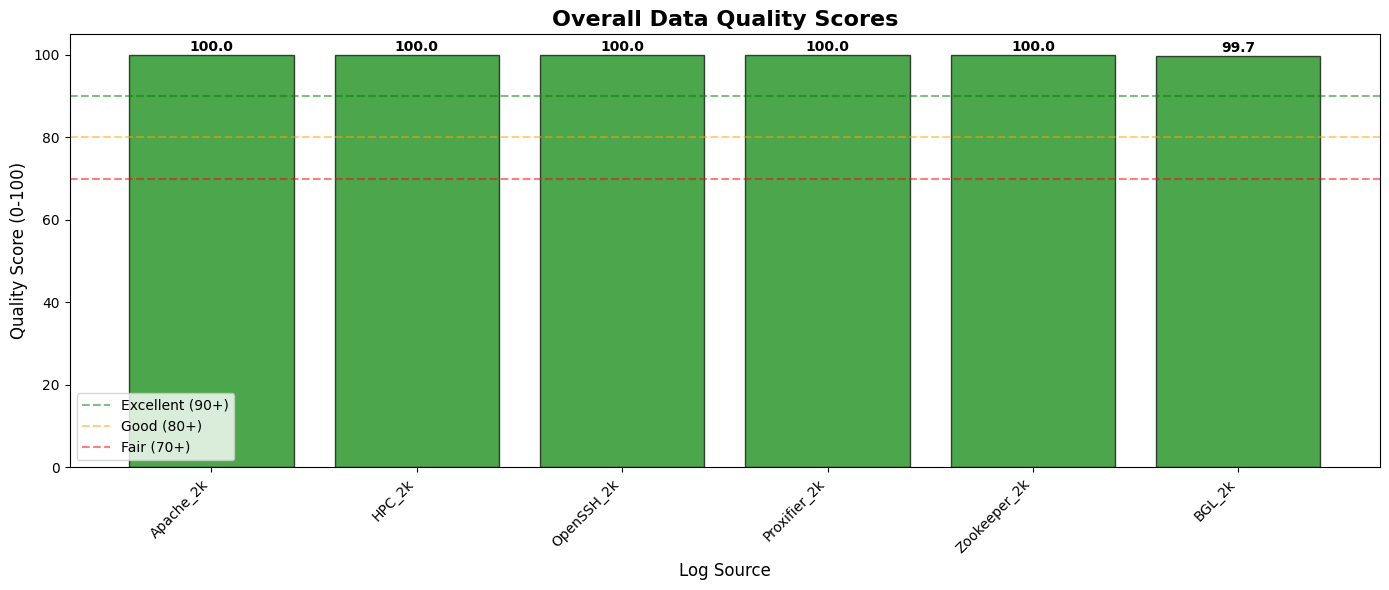

In [16]:
if 'labeled_quality_reports' in locals() and labeled_quality_reports:
    plt.figure(figsize=fig_size)

    overall_scores = [report['overall_quality_score'] for report in labeled_quality_reports]
    dataset_names_quality = [report['dataset_name'].replace('_labeled.csv', '') for report in labeled_quality_reports]

    sorted_data = sorted(zip(dataset_names_quality, overall_scores), key=lambda x: x[1], reverse=True)
    sorted_names, sorted_scores = zip(*sorted_data)

    colors = ['green' if score >= 90 else 'lightgreen' if score >= 80 else 'orange' if score >= 70 else 'red'
              for score in sorted_scores]

    bars = plt.bar(range(len(sorted_names)), sorted_scores, color=colors, alpha=0.7, edgecolor='black')
    plt.title('Overall Data Quality Scores', fontsize=16, fontweight='bold')
    plt.xlabel('Log Source', fontsize=12)
    plt.ylabel('Quality Score (0-100)', fontsize=12)
    plt.xticks(range(len(sorted_names)), sorted_names, rotation=45, ha='right')
    plt.ylim(0, 105)

    for bar, score in zip(bars, sorted_scores):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1, f'{score:.1f}', 
                 ha='center', fontweight='bold', fontsize=10)

    plt.axhline(y=90, color='green', linestyle='--', alpha=0.5, label='Excellent (90+)')
    plt.axhline(y=80, color='orange', linestyle='--', alpha=0.5, label='Good (80+)')
    plt.axhline(y=70, color='red', linestyle='--', alpha=0.5, label='Fair (70+)')
    plt.legend()
    plt.tight_layout()
    plt.show()

In [20]:
def generate_ml_readiness_report(datasets_info, quality_reports, label_analyses):
    print("               ML READINESS ASSESSMENT REPORT")
    print("="*60)
    
    if not datasets_info:
        print("No datasets available for ML readiness assessment")
        return
    
    total_datasets = len(datasets_info)
    datasets_with_labels = len([info for info in datasets_info if info['has_labels']])
    
    print(f"\n1. DATASET OVERVIEW")
    print(f"   Total datasets: {total_datasets}")
    print(f"   Labeled datasets: {datasets_with_labels}/{total_datasets} ({datasets_with_labels/total_datasets*100:.1f}%)")
    
    total_records = sum([info['rows'] for info in datasets_info])
    print(f"   Total records: {total_records:,}")
    print(f"   Average records per dataset: {total_records//total_datasets:,}")
    
    print(f"\n2. DATA QUALITY ASSESSMENT")
    if quality_reports:
        avg_quality = np.mean([report['overall_quality_score'] for report in quality_reports])
        high_quality_datasets = len([r for r in quality_reports if r['overall_quality_score'] >= 80])
        
        print(f"   Average quality score: {avg_quality:.1f}/100")
        print(f"   High quality datasets (≥80): {high_quality_datasets}/{len(quality_reports)} ({high_quality_datasets/len(quality_reports)*100:.1f}%)")
    
    print(f"\n3. LABEL DISTRIBUTION ANALYSIS")
    if label_analyses:
        total_labeled_records = sum([analysis['total_records'] for analysis in label_analyses])
        total_anomalies = sum([analysis['anomaly_count'] for analysis in label_analyses])
        overall_anomaly_rate = (total_anomalies / total_labeled_records * 100) if total_labeled_records > 0 else 0
        
        print(f"   Total labeled records: {total_labeled_records:,}")
        print(f"   Total anomalies: {total_anomalies:,}")
        print(f"   Overall anomaly rate: {overall_anomaly_rate:.1f}%")
        
        # Class imbalance analysis
        balanced_datasets = len([a for a in label_analyses if 10 <= a['anomaly_rate'] <= 40])
        imbalanced_datasets = len(label_analyses) - balanced_datasets
        
        print(f"   Balanced datasets (10-40% anomalies): {balanced_datasets}")
        print(f"   Imbalanced datasets: {imbalanced_datasets}")
    
    print(f"\n4. ML READINESS SCORE")
    readiness_factors = []
    
    # Factor 1: Data availability (0-25 points)
    data_availability = min(25, (total_records / 100000) * 25)  # Max at 100k records
    readiness_factors.append(('Data Volume', data_availability, 25))
    
    # Factor 2: Data quality (0-25 points)
    if quality_reports:
        avg_quality_score = np.mean([report['overall_quality_score'] for report in quality_reports])
        data_quality = (avg_quality_score / 100) * 25
    else:
        data_quality = 0
    readiness_factors.append(('Data Quality', data_quality, 25))
    
    # Factor 3: Label completeness (0-25 points)
    label_completeness = (datasets_with_labels / total_datasets) * 25
    readiness_factors.append(('Label Coverage', label_completeness, 25))
    
    # Factor 4: Class balance (0-25 points)
    if label_analyses:
        # Penalize extreme imbalance
        balance_scores = []
        for analysis in label_analyses:
            rate = analysis['anomaly_rate']
            if 5 <= rate <= 45:  # Good balance
                balance_scores.append(25)
            elif 1 <= rate <= 60:  # Acceptable
                balance_scores.append(15)
            else:  # Poor balance
                balance_scores.append(5)
        class_balance = np.mean(balance_scores) if balance_scores else 0
    else:
        class_balance = 0
    readiness_factors.append(('Class Balance', class_balance, 25))
    
    total_readiness = sum([factor[1] for factor in readiness_factors])
    
    print(f"   Readiness Breakdown:")
    for factor_name, score, max_score in readiness_factors:
        print(f"     {factor_name:<15}: {score:5.1f}/{max_score} ({score/max_score*100:.1f}%)")
    
    print(f"\n   OVERALL ML READINESS: {total_readiness:.1f}/100")
    
    # Readiness classification
    if total_readiness >= 80:
        readiness_class = "EXCELLENT - Ready for production ML"
    elif total_readiness >= 65:
        readiness_class = "GOOD - Ready for ML with minor improvements"
    elif total_readiness >= 50:
        readiness_class = "FAIR - Requires some preprocessing"
    elif total_readiness >= 35:
        readiness_class = "POOR - Significant preprocessing needed"
    else:
        readiness_class = "CRITICAL - Major data issues to resolve"
    
    print(f"   Classification: {readiness_class}")
    
    print(f"\n5. RECOMMENDATIONS")
    recommendations = []
    
    if avg_quality < 80:
        recommendations.append("• Improve data quality through cleaning and validation")
    
    if datasets_with_labels < total_datasets:
        recommendations.append(f"• Complete labeling for {total_datasets - datasets_with_labels} remaining datasets")
    
    if label_analyses:
        extreme_imbalance = [a for a in label_analyses if a['anomaly_rate'] < 1 or a['anomaly_rate'] > 60]
        if extreme_imbalance:
            recommendations.append(f"• Address class imbalance in {len(extreme_imbalance)} datasets using sampling techniques")
    
    if total_records < 50000:
        recommendations.append("• Consider collecting more data for robust model training")
    
    if not recommendations:
        recommendations.append("• Data appears ready for ML! Consider advanced feature engineering")
    
    for rec in recommendations:
        print(f"   {rec}")
    
    return {
        'total_readiness': total_readiness,
        'readiness_class': readiness_class,
        'factors': readiness_factors,
        'recommendations': recommendations
    }

def generate_dataset_comparison_table(datasets_info, quality_reports, label_analyses):
    """Generate a comprehensive comparison table"""
    print(f"\n" + "="*100)
    print("                                    DATASET COMPARISON TABLE")
    print("="*100)
    
    # Create comparison data
    comparison_data = []
    
    for info in datasets_info:
        dataset_name = info['name'].replace('_labeled.csv', '')
        
        # Get quality info
        quality_info = next((q for q in quality_reports if q['dataset_name'] == info['name']), None)
        quality_score = quality_info['overall_quality_score'] if quality_info else 0
        
        # Get label info
        label_info = next((l for l in label_analyses if l['dataset'] == dataset_name), None)
        anomaly_rate = label_info['anomaly_rate'] if label_info else 0
        total_anomalies = label_info['anomaly_count'] if label_info else 0
        
        comparison_data.append({
            'Dataset': dataset_name,
            'Log Type': info['log_type'],
            'Records': info['rows'],
            'Columns': info['columns'],
            'Quality': quality_score,
            'Anomaly Rate': anomaly_rate,
            'Anomalies': total_anomalies,
            'Has Labels': '✓' if info['has_labels'] else '✗',
            'Timestamps': len(info['timestamp_columns'])
        })
    
    # Create and display table
    comparison_df = pd.DataFrame(comparison_data)
    
    # Sort by quality score (descending)
    comparison_df = comparison_df.sort_values('Quality', ascending=False)
    
    print(f"{'Dataset':<15} {'Type':<10} {'Records':<10} {'Cols':<5} {'Quality':<8} {'Anomaly%':<9} {'Anomalies':<10} {'Labels':<7} {'TS Cols':<7}")
    print("-" * 100)
    
    for _, row in comparison_df.iterrows():
        print(f"{row['Dataset']:<15} {row['Log Type']:<10} {row['Records']:<10,} {row['Columns']:<5} "
              f"{row['Quality']:<8.1f} {row['Anomaly Rate']:<9.1f} {row['Anomalies']:<10,} "
              f"{row['Has Labels']:<7} {row['Timestamps']:<7}")
    
    return comparison_df

# Run advanced analysis
if labeled_datasets_info and labeled_quality_reports:
    # Generate ML readiness report
    ml_readiness = generate_ml_readiness_report(
        labeled_datasets_info, 
        labeled_quality_reports, 
        label_analyses if 'label_analyses' in locals() else []
    )
    
    # Generate comparison table
    comparison_table = generate_dataset_comparison_table(
        labeled_datasets_info, 
        labeled_quality_reports, 
        label_analyses if 'label_analyses' in locals() else []
    )
    
else:
    print("Insufficient data for advanced analysis")


               ML READINESS ASSESSMENT REPORT

1. DATASET OVERVIEW
   Total datasets: 6
   Labeled datasets: 1/6 (16.7%)
   Total records: 12,000
   Average records per dataset: 2,000

2. DATA QUALITY ASSESSMENT
   Average quality score: 99.9/100
   High quality datasets (≥80): 6/6 (100.0%)

3. LABEL DISTRIBUTION ANALYSIS

4. ML READINESS SCORE
   Readiness Breakdown:
     Data Volume    :   3.0/25 (12.0%)
     Data Quality   :  25.0/25 (99.9%)
     Label Coverage :   4.2/25 (16.7%)
     Class Balance  :   0.0/25 (0.0%)

   OVERALL ML READINESS: 32.2/100
   Classification: CRITICAL - Major data issues to resolve

5. RECOMMENDATIONS
   • Complete labeling for 5 remaining datasets
   • Consider collecting more data for robust model training

                                    DATASET COMPARISON TABLE
Dataset         Type       Records    Cols  Quality  Anomaly%  Anomalies  Labels  TS Cols
--------------------------------------------------------------------------------------------------